In [1]:
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch,torchvision
from torch.nn import *
from sklearn.model_selection import *
from tqdm import tqdm
import cv2,os
from torch.optim import *
import pickle
import wandb

PROJECT_NAME = 'Trying-to-Turn-GrayScale-Images-to-Color-Images-I-dont-know-how-but-I-am-going-to-try'
device = 'cuda:0'
np.random.seed(21)
random.seed(21)
torch.manual_seed(21)

In [2]:
def load_data():
    data = []
    for file in tqdm(os.listdir('./data/')):
        X_one = cv2.imread(f'./data/{file}',cv2.IMREAD_GRAYSCALE)
        X_one = cv2.resize(X_one,(56,56))
        y_one = cv2.imread(f'./data/{file}')
        y_one = cv2.resize(y_one,(56,56))
        data.append([X_one,y_one])
    return data

In [3]:
data = load_data()

In [4]:
np.random.shuffle(data)

In [5]:
X = []
y = []

In [6]:
for d in data:
    X.append(d[0])
    y.append(d[1])

In [7]:
X = torch.from_numpy(np.array(X)).view(-1,1*56*56).to(device).float()
y = torch.from_numpy(np.array(y)).view(-1,3*56*56).to(device).float()

In [8]:
def predict(model):
    for file in os.listdir('./test_data/'):
        X_one = cv2.imread(f'./data/{file}',cv2.IMREAD_GRAYSCALE)
        X_one = cv2.resize(X_one,(56,56))
        preds = model(X_one)
        preds = preds.view(-1,1*56*56)
        plt.figure(figsize=(12,6))
        plt.imshow(preds)
        plt.savefig(f'./preds/{file}')
        plt.close()

In [9]:
class Model_1(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.max_pool2d = MaxPool2d((2,2),(2,2))
        self.conv1 = Conv2d(1,7,(5,5))
        self.conv1bn = BatchNorm2d(7)
        self.conv2 = Conv2d(7,14,(5,5))
        self.conv2bn = BatchNorm2d(14)
        self.conv3 = Conv2d(14,21,(5,5))
        self.conv3bn = BatchNorm2d(21)
        self.conv4 = Conv2d(21,28,(5,5))
        self.conv4bn = BatchNorm2d(28)
        self.conv5 = Conv2d(28,37,(5,5))
        self.conv5bn = BatchNorm2d(37)
        self.linear1 = Linear(37,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,256)
        self.linear2bn = BatchNorm1d(256)
        self.output = Linear(256,3*56*56)
    
    def forward(self,X):
        X = X.view(-1,1,56,56)
        preds = self.max_pool2d(self.activation(self.conv1bn(self.conv1(X))))
        preds = self.max_pool2d(self.activation(self.conv2bn(self.conv2(preds))))
        preds = self.max_pool2d(self.activation(self.conv3bn(self.conv3(preds))))
        preds = self.max_pool2d(self.activation(self.conv4bn(self.conv4(preds))))
        preds = self.max_pool2d(self.activation(self.conv5bn(self.conv5(preds))))
        print(preds.shape)
        preds = preds.view(-1)
        preds = self.activation(self.linear1bn(self.linear1(preds)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.output(preds)
        return preds

In [10]:
class Model_2(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.linear1 = Linear(3*56*56,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,512)
        self.linear2bn = BatchNorm1d(512)
        self.linear3 = Linear(512,1024)
        self.linear3bn = BatchNorm1d(1024)
        self.linear4 = Linear(1024,1024)
        self.linear4bn = BatchNorm1d(1024)
        self.output = Linear(1024,3*56*56)
    
    def forward(self,X):
        preds = self.activation(self.linear1bn(self.linear1(X)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.activation(self.linear3bn(self.linear3(preds)))
        preds = self.activation(self.linear4bn(self.linear4(preds)))
        preds = self.output(preds)
        return preds

In [11]:
model = Model_1().to(device)

In [12]:
criterion = MSELoss()

In [13]:
optimizer = Adam(model.parameters(),lr=0.001)

In [14]:
epochs = 100

In [15]:
batch_size = 32

In [16]:
wandb.init(project=PROJECT_NAME,name='Model_1-baseline')
for _ in tqdm(range(epochs)):
    for idx in range(0,len(X),batch_size):
        X_batch = X[idx:idx+batch_size].to(device).float().view(-1,1*56*56)
        y_batch = y[idx:idx+batch_size].to(device).float().view(-1,3*56*56)
        preds = model(X_batch)
        loss = criterion(preds,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    wandb.log({'Loss':loss.item()})
    predict(model)
    for file in os.listdir('./preds/'):
        wandb.log({f'Img/{file}':wandb.Image(cv2.imread(f'./preds/{file}'))})
wandb.finish()

In [17]:
class Model_1(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.max_pool2d = MaxPool2d((2,2),(2,2))
        self.conv1 = Conv2d(1,7,(5,5))
        self.conv1bn = BatchNorm2d(7)
        self.conv2 = Conv2d(7,14,(5,5))
        self.conv2bn = BatchNorm2d(14)
        self.conv3 = Conv2d(14,21,(5,5))
        self.conv3bn = BatchNorm2d(21)
        self.linear1 = Linear(37,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,256)
        self.linear2bn = BatchNorm1d(256)
        self.output = Linear(256,3*56*56)
    
    def forward(self,X):
        X = X.view(-1,1,56,56)
        preds = self.max_pool2d(self.activation(self.conv1bn(self.conv1(X))))
        preds = self.max_pool2d(self.activation(self.conv2bn(self.conv2(preds))))
        preds = self.max_pool2d(self.activation(self.conv3bn(self.conv3(preds))))
        print(preds.shape)
        preds = preds.view(-1)
        preds = self.activation(self.linear1bn(self.linear1(preds)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.output(preds)
        return preds

In [18]:
class Model_2(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.linear1 = Linear(3*56*56,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,512)
        self.linear2bn = BatchNorm1d(512)
        self.linear3 = Linear(512,1024)
        self.linear3bn = BatchNorm1d(1024)
        self.linear4 = Linear(1024,1024)
        self.linear4bn = BatchNorm1d(1024)
        self.output = Linear(1024,3*56*56)
    
    def forward(self,X):
        preds = self.activation(self.linear1bn(self.linear1(X)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.activation(self.linear3bn(self.linear3(preds)))
        preds = self.activation(self.linear4bn(self.linear4(preds)))
        preds = self.output(preds)
        return preds

In [19]:
model = Model_1().to(device)

In [20]:
criterion = MSELoss()

In [21]:
optimizer = Adam(model.parameters(),lr=0.001)

In [22]:
epochs = 100

In [23]:
batch_size = 32

In [24]:
wandb.init(project=PROJECT_NAME,name='Model_1-baseline')
for _ in tqdm(range(epochs)):
    for idx in range(0,len(X),batch_size):
        X_batch = X[idx:idx+batch_size].to(device).float().view(-1,1*56*56)
        y_batch = y[idx:idx+batch_size].to(device).float().view(-1,3*56*56)
        preds = model(X_batch)
        loss = criterion(preds,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    wandb.log({'Loss':loss.item()})
    predict(model)
    for file in os.listdir('./preds/'):
        wandb.log({f'Img/{file}':wandb.Image(cv2.imread(f'./preds/{file}'))})
wandb.finish()

In [25]:
class Model_1(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.max_pool2d = MaxPool2d((2,2),(2,2))
        self.conv1 = Conv2d(1,7,(5,5))
        self.conv1bn = BatchNorm2d(7)
        self.conv2 = Conv2d(7,14,(5,5))
        self.conv2bn = BatchNorm2d(14)
        self.conv3 = Conv2d(14,21,(5,5))
        self.conv3bn = BatchNorm2d(21)
        self.linear1 = Linear(21*3*3,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,256)
        self.linear2bn = BatchNorm1d(256)
        self.output = Linear(256,3*56*56)
    
    def forward(self,X):
        X = X.view(-1,1,56,56)
        preds = self.max_pool2d(self.activation(self.conv1bn(self.conv1(X))))
        preds = self.max_pool2d(self.activation(self.conv2bn(self.conv2(preds))))
        preds = self.max_pool2d(self.activation(self.conv3bn(self.conv3(preds))))
        print(preds.shape)
        preds = preds.view(-1,21*3*3)
        preds = self.activation(self.linear1bn(self.linear1(preds)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.output(preds)
        return preds

In [26]:
class Model_2(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.linear1 = Linear(3*56*56,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,512)
        self.linear2bn = BatchNorm1d(512)
        self.linear3 = Linear(512,1024)
        self.linear3bn = BatchNorm1d(1024)
        self.linear4 = Linear(1024,1024)
        self.linear4bn = BatchNorm1d(1024)
        self.output = Linear(1024,3*56*56)
    
    def forward(self,X):
        preds = self.activation(self.linear1bn(self.linear1(X)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.activation(self.linear3bn(self.linear3(preds)))
        preds = self.activation(self.linear4bn(self.linear4(preds)))
        preds = self.output(preds)
        return preds

In [27]:
model = Model_1().to(device)

In [28]:
criterion = MSELoss()

In [29]:
optimizer = Adam(model.parameters(),lr=0.001)

In [30]:
epochs = 100

In [31]:
batch_size = 32

In [32]:
wandb.init(project=PROJECT_NAME,name='Model_1-baseline')
for _ in tqdm(range(epochs)):
    for idx in range(0,len(X),batch_size):
        X_batch = X[idx:idx+batch_size].to(device).float().view(-1,1*56*56)
        y_batch = y[idx:idx+batch_size].to(device).float().view(-1,3*56*56)
        preds = model(X_batch)
        loss = criterion(preds,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    wandb.log({'Loss':loss.item()})
    predict(model)
    for file in os.listdir('./preds/'):
        wandb.log({f'Img/{file}':wandb.Image(cv2.imread(f'./preds/{file}'))})
wandb.finish()

In [33]:
def predict(model):
    for file in os.listdir('./test_data/'):
        X_one = cv2.imread(f'./data/{file}',cv2.IMREAD_GRAYSCALE)
        X_one = cv2.resize(X_one,(56,56))
        preds = model(torch.from_numpy(np.array(X_one)).to(device).float())
        preds = preds.view(-1,3*56*56)
        plt.figure(figsize=(12,6))
        plt.imshow(preds)
        plt.savefig(f'./preds/{file}')
        plt.close()

In [34]:
class Model_1(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.max_pool2d = MaxPool2d((2,2),(2,2))
        self.conv1 = Conv2d(1,7,(5,5))
        self.conv1bn = BatchNorm2d(7)
        self.conv2 = Conv2d(7,14,(5,5))
        self.conv2bn = BatchNorm2d(14)
        self.conv3 = Conv2d(14,21,(5,5))
        self.conv3bn = BatchNorm2d(21)
        self.linear1 = Linear(21*3*3,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,256)
        self.linear2bn = BatchNorm1d(256)
        self.output = Linear(256,3*56*56)
    
    def forward(self,X):
        X = X.view(-1,1,56,56)
        preds = self.max_pool2d(self.activation(self.conv1bn(self.conv1(X))))
        preds = self.max_pool2d(self.activation(self.conv2bn(self.conv2(preds))))
        preds = self.max_pool2d(self.activation(self.conv3bn(self.conv3(preds))))
#         print(preds.shape)
        preds = preds.view(-1,21*3*3)
        preds = self.activation(self.linear1bn(self.linear1(preds)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.output(preds)
        return preds

In [35]:
class Model_2(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.linear1 = Linear(3*56*56,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,512)
        self.linear2bn = BatchNorm1d(512)
        self.linear3 = Linear(512,1024)
        self.linear3bn = BatchNorm1d(1024)
        self.linear4 = Linear(1024,1024)
        self.linear4bn = BatchNorm1d(1024)
        self.output = Linear(1024,3*56*56)
    
    def forward(self,X):
        preds = self.activation(self.linear1bn(self.linear1(X)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.activation(self.linear3bn(self.linear3(preds)))
        preds = self.activation(self.linear4bn(self.linear4(preds)))
        preds = self.output(preds)
        return preds

In [36]:
model = Model_1().to(device)

In [37]:
criterion = MSELoss()

In [38]:
optimizer = Adam(model.parameters(),lr=0.001)

In [39]:
epochs = 100

In [40]:
batch_size = 32

In [41]:
wandb.init(project=PROJECT_NAME,name='Model_1-baseline')
for _ in tqdm(range(epochs)):
    for idx in range(0,len(X),batch_size):
        X_batch = X[idx:idx+batch_size].to(device).float().view(-1,1*56*56)
        y_batch = y[idx:idx+batch_size].to(device).float().view(-1,3*56*56)
        preds = model(X_batch)
        loss = criterion(preds,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    wandb.log({'Loss':loss.item()})
    predict(model)
    for file in os.listdir('./preds/'):
        wandb.log({f'Img/{file}':wandb.Image(cv2.imread(f'./preds/{file}'))})
wandb.finish()

In [42]:
def predict(model):
    model.eval()
    for file in os.listdir('./test_data/'):
        X_one = cv2.imread(f'./data/{file}',cv2.IMREAD_GRAYSCALE)
        X_one = cv2.resize(X_one,(56,56))
        preds = model(torch.from_numpy(np.array(X_one)).to(device).float())
        preds = preds.view(-1,3*56*56)
        plt.figure(figsize=(12,6))
        plt.imshow(preds)
        plt.savefig(f'./preds/{file}')
        plt.close()
    model.train()

In [43]:
class Model_1(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.max_pool2d = MaxPool2d((2,2),(2,2))
        self.conv1 = Conv2d(1,7,(5,5))
        self.conv1bn = BatchNorm2d(7)
        self.conv2 = Conv2d(7,14,(5,5))
        self.conv2bn = BatchNorm2d(14)
        self.conv3 = Conv2d(14,21,(5,5))
        self.conv3bn = BatchNorm2d(21)
        self.linear1 = Linear(21*3*3,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,256)
        self.linear2bn = BatchNorm1d(256)
        self.output = Linear(256,3*56*56)
    
    def forward(self,X):
        X = X.view(-1,1,56,56)
        preds = self.max_pool2d(self.activation(self.conv1bn(self.conv1(X))))
        preds = self.max_pool2d(self.activation(self.conv2bn(self.conv2(preds))))
        preds = self.max_pool2d(self.activation(self.conv3bn(self.conv3(preds))))
#         print(preds.shape)
        preds = preds.view(-1,21*3*3)
        preds = self.activation(self.linear1bn(self.linear1(preds)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.output(preds)
        return preds

In [44]:
class Model_2(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.linear1 = Linear(3*56*56,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,512)
        self.linear2bn = BatchNorm1d(512)
        self.linear3 = Linear(512,1024)
        self.linear3bn = BatchNorm1d(1024)
        self.linear4 = Linear(1024,1024)
        self.linear4bn = BatchNorm1d(1024)
        self.output = Linear(1024,3*56*56)
    
    def forward(self,X):
        preds = self.activation(self.linear1bn(self.linear1(X)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.activation(self.linear3bn(self.linear3(preds)))
        preds = self.activation(self.linear4bn(self.linear4(preds)))
        preds = self.output(preds)
        return preds

In [45]:
model = Model_1().to(device)

In [46]:
criterion = MSELoss()

In [47]:
optimizer = Adam(model.parameters(),lr=0.001)

In [48]:
epochs = 100

In [49]:
batch_size = 32

In [50]:
wandb.init(project=PROJECT_NAME,name='Model_1-baseline')
for _ in tqdm(range(epochs)):
    for idx in range(0,len(X),batch_size):
        X_batch = X[idx:idx+batch_size].to(device).float().view(-1,1*56*56)
        y_batch = y[idx:idx+batch_size].to(device).float().view(-1,3*56*56)
        preds = model(X_batch)
        loss = criterion(preds,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    wandb.log({'Loss':loss.item()})
    predict(model)
    for file in os.listdir('./preds/'):
        wandb.log({f'Img/{file}':wandb.Image(cv2.imread(f'./preds/{file}'))})
wandb.finish()

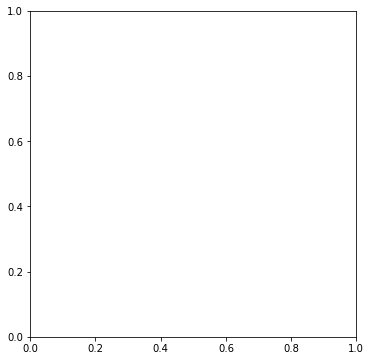

In [51]:
def predict(model):
    model.eval()
    for file in os.listdir('./test_data/'):
        X_one = cv2.imread(f'./data/{file}',cv2.IMREAD_GRAYSCALE)
        X_one = cv2.resize(X_one,(56,56))
        preds = model(torch.from_numpy(np.array(X_one)).to(device).float())
        preds = preds.view(-1,3*56*56)
        plt.figure(figsize=(12,6))
        plt.imshow(preds.cpu().detach().numpy())
        plt.savefig(f'./preds/{file}')
        plt.close()
    model.train()

In [52]:
class Model_1(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.max_pool2d = MaxPool2d((2,2),(2,2))
        self.conv1 = Conv2d(1,7,(5,5))
        self.conv1bn = BatchNorm2d(7)
        self.conv2 = Conv2d(7,14,(5,5))
        self.conv2bn = BatchNorm2d(14)
        self.conv3 = Conv2d(14,21,(5,5))
        self.conv3bn = BatchNorm2d(21)
        self.linear1 = Linear(21*3*3,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,256)
        self.linear2bn = BatchNorm1d(256)
        self.output = Linear(256,3*56*56)
    
    def forward(self,X):
        X = X.view(-1,1,56,56)
        preds = self.max_pool2d(self.activation(self.conv1bn(self.conv1(X))))
        preds = self.max_pool2d(self.activation(self.conv2bn(self.conv2(preds))))
        preds = self.max_pool2d(self.activation(self.conv3bn(self.conv3(preds))))
#         print(preds.shape)
        preds = preds.view(-1,21*3*3)
        preds = self.activation(self.linear1bn(self.linear1(preds)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.output(preds)
        return preds

In [53]:
class Model_2(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.linear1 = Linear(3*56*56,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,512)
        self.linear2bn = BatchNorm1d(512)
        self.linear3 = Linear(512,1024)
        self.linear3bn = BatchNorm1d(1024)
        self.linear4 = Linear(1024,1024)
        self.linear4bn = BatchNorm1d(1024)
        self.output = Linear(1024,3*56*56)
    
    def forward(self,X):
        preds = self.activation(self.linear1bn(self.linear1(X)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.activation(self.linear3bn(self.linear3(preds)))
        preds = self.activation(self.linear4bn(self.linear4(preds)))
        preds = self.output(preds)
        return preds

In [54]:
model = Model_1().to(device)

In [55]:
criterion = MSELoss()

In [56]:
optimizer = Adam(model.parameters(),lr=0.001)

In [57]:
epochs = 100

In [58]:
batch_size = 32

In [59]:
wandb.init(project=PROJECT_NAME,name='Model_1-baseline')
for _ in tqdm(range(epochs)):
    for idx in range(0,len(X),batch_size):
        X_batch = X[idx:idx+batch_size].to(device).float().view(-1,1*56*56)
        y_batch = y[idx:idx+batch_size].to(device).float().view(-1,3*56*56)
        preds = model(X_batch)
        loss = criterion(preds,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    wandb.log({'Loss':loss.item()})
    predict(model)
    for file in os.listdir('./preds/'):
        wandb.log({f'Img/{file}':wandb.Image(cv2.imread(f'./preds/{file}'))})
wandb.finish()